<a href="https://colab.research.google.com/github/kevinsu-rgb/Senior_Design_TI_Project/blob/main/ticnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [163]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

%matplotlib inline

In [164]:
## seed
#seed = 15
#np.random.seed(seed)
#torch.manual_seed(seed)
#torch.cuda.manual_seed(seed)
#torch.backends.cudnn.deterministic=True

In [165]:
# Setup the device
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [166]:
def decode_heatmap_csv(filepath):
    df = pd.read_csv(filepath, header=None)
    numpy_array = df.values
    tensor = torch.from_numpy(numpy_array).float()
    return tensor

class HeatmapDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = []
        self.num_classes = 0

        for label_name in sorted(os.listdir(root_dir)):
            label_dir_path = os.path.join(root_dir, label_name)
            if os.path.isdir(label_dir_path):
                if label_name not in self.class_to_idx:
                    self.class_to_idx[label_name] = self.num_classes
                    self.idx_to_class.append(label_name)
                    self.num_classes += 1

                label_idx = self.class_to_idx[label_name]
                for heatmap_filename in os.listdir(label_dir_path):
                    if heatmap_filename.endswith('.csv'):
                        heatmap_filepath = os.path.join(label_dir_path, heatmap_filename)
                        self.samples.append((heatmap_filepath, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        heatmap_path, label = self.samples[idx]

        image = decode_heatmap_csv(heatmap_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [167]:
root_directory = 'data'
heatmap_dataset = HeatmapDataset(root_directory)

print(f"\nNumber of samples: {len(heatmap_dataset)}")
print(f"Class to index mapping: {heatmap_dataset.class_to_idx}")
print(f"Index to class mapping: {heatmap_dataset.idx_to_class}")

sample_heatmap, sample_label = heatmap_dataset[0]


Number of samples: 200
Class to index mapping: {'.ipynb_checkpoints': 0, 'falling': 1, 'sitting': 2, 'standing': 3, 'walking': 4}
Index to class mapping: ['.ipynb_checkpoints', 'falling', 'sitting', 'standing', 'walking']


In [168]:
class NeuralNetwork(nn.Module):
  def __init__(self):
      super().__init__()
      self.flatten = nn.Flatten()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(64*32, 512),
          nn.ReLU(),
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, 4),
      )
  def forward(self, x):
      x = self.flatten(x)
      logits = self.linear_relu_stack(x)
      return logits

In [169]:
from torch.utils.data import random_split

train_size = int(0.8 * len(heatmap_dataset))
test_size = len(heatmap_dataset) - train_size

train_dataset, test_dataset = random_split(heatmap_dataset, [train_size, test_size])

print(f"Number of samples in training dataset: {len(train_dataset)}")
print(f"Number of samples in testing dataset: {len(test_dataset)}")

Number of samples in training dataset: 160
Number of samples in testing dataset: 40


In [170]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Number of batches in training DataLoader: {len(train_dataloader)}")
print(f"Number of batches in testing DataLoader: {len(test_dataloader)}")

Number of batches in training DataLoader: 3
Number of batches in testing DataLoader: 1


In [171]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Model instantiated.")
print("Loss function (CrossEntropyLoss) defined.")
print("Optimizer (Adam) set up.")

Model instantiated.
Loss function (CrossEntropyLoss) defined.
Optimizer (Adam) set up.


In [172]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    total_samples = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        total_samples += X.size(0)

    avg_loss = total_loss / total_samples
    print(f"Average training loss: {avg_loss:.4f}")
    return avg_loss

In [173]:
def test_loop(dataloader, model, loss_fn):
    model.eval() # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad(): # Disable gradient calculation for inference
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            total_loss += loss.item() * X.size(0)
            total_samples += X.size(0)

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples

    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f} \n")
    return avg_loss, accuracy

In [174]:
def decode_heatmap_csv(filepath):
    df = pd.read_csv(filepath, header=None)
    numpy_array = df.values
    tensor = torch.from_numpy(numpy_array).float()
    return tensor

class HeatmapDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = []
        self.num_classes = 0

        for label_name in sorted(os.listdir(root_dir)):
            # Skip the '.ipynb_checkpoints' directory
            if label_name == '.ipynb_checkpoints':
                continue

            label_dir_path = os.path.join(root_dir, label_name)
            if os.path.isdir(label_dir_path):
                if label_name not in self.class_to_idx:
                    self.class_to_idx[label_name] = self.num_classes
                    self.idx_to_class.append(label_name)
                    self.num_classes += 1

                label_idx = self.class_to_idx[label_name]
                for heatmap_filename in os.listdir(label_dir_path):
                    if heatmap_filename.endswith('.csv'):
                        heatmap_filepath = os.path.join(label_dir_path, heatmap_filename)
                        self.samples.append((heatmap_filepath, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        heatmap_path, label = self.samples[idx]

        image = decode_heatmap_csv(heatmap_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [175]:
root_directory = 'data'
heatmap_dataset = HeatmapDataset(root_directory)

print(f"\nNumber of samples: {len(heatmap_dataset)}")
print(f"Class to index mapping: {heatmap_dataset.class_to_idx}")
print(f"Index to class mapping: {heatmap_dataset.idx_to_class}")

sample_heatmap, sample_label = heatmap_dataset[0]
print(f"\nSample Heatmap shape: {sample_heatmap.shape}")
print(f"Sample Label (index): {sample_label}")
print(f"Sample Label (class name): {heatmap_dataset.idx_to_class[sample_label]}")


Number of samples: 200
Class to index mapping: {'falling': 0, 'sitting': 1, 'standing': 2, 'walking': 3}
Index to class mapping: ['falling', 'sitting', 'standing', 'walking']

Sample Heatmap shape: torch.Size([64, 32])
Sample Label (index): 0
Sample Label (class name): falling


In [176]:
from torch.utils.data import random_split

train_size = int(0.8 * len(heatmap_dataset))
test_size = len(heatmap_dataset) - train_size

train_dataset, test_dataset = random_split(heatmap_dataset, [train_size, test_size])

print(f"Number of samples in training dataset: {len(train_dataset)}")
print(f"Number of samples in testing dataset: {len(test_dataset)}")

Number of samples in training dataset: 160
Number of samples in testing dataset: 40


In [180]:
batch_size = 10

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Number of batches in training DataLoader: {len(train_dataloader)}")
print(f"Number of batches in testing DataLoader: {len(test_dataloader)}")

Number of batches in training DataLoader: 16
Number of batches in testing DataLoader: 4


In [181]:
epochs = 10
train_losses = []
test_losses = []
test_accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------------")
    avg_train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    avg_test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
print("Done!")

Epoch 1
-----------------------------------
Average training loss: 0.0161
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.141488 

Epoch 2
-----------------------------------
Average training loss: 0.0029
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.087944 

Epoch 3
-----------------------------------
Average training loss: 0.0010
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.034909 

Epoch 4
-----------------------------------
Average training loss: 0.0005
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.047171 

Epoch 5
-----------------------------------
Average training loss: 0.0003
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.057056 

Epoch 6
-----------------------------------
Average training loss: 0.0002
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.047755 

Epoch 7
-----------------------------------
Average training loss: 0.0002
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.043022 

Epoch 8
-----------------------------------
Average training loss: 0.0002
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.0

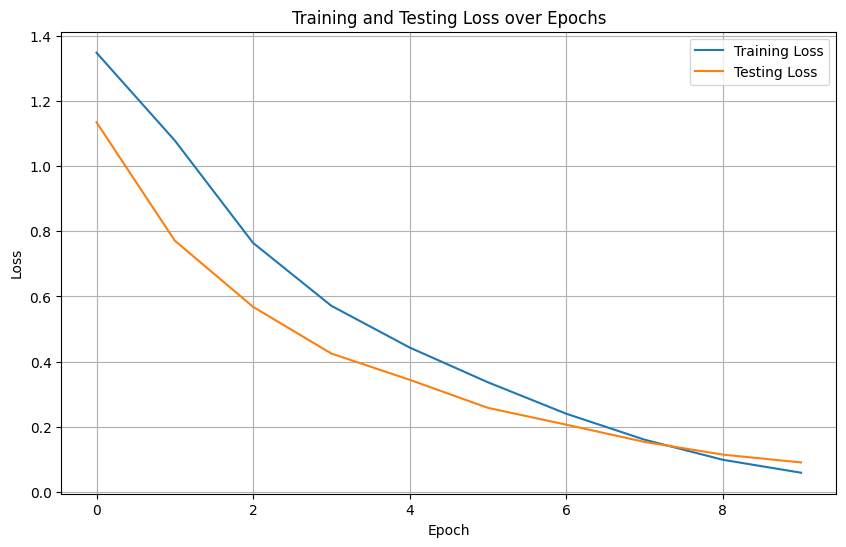

In [179]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training')
plt.legend()
plt.grid(True)
plt.show()